In [114]:
import os
os.getcwd()
os.chdir('/mnt/home/agoldmaier/repos/master-thesis-dissaggregator')

In [115]:
# %%
import datetime
from datetime import timedelta

import holidays
import pandas as pd

from src import logger
from src.configs.data import *
from src.data_access.local_reader import *
from src.data_processing.consumption import *
from src.data_processing.temperature import *
from src.pipeline.pipe_applications import *
from src.utils.utils import *

In [116]:
# %%
def get_timezone(alpha2code):

    """
      getting timezone of country in Europe
    """

    timezonemap = {

        'AT': 'Europe/Berlin', 'BE': 'Europe/Berlin', 'BG': 'Europe/Sofia', 'BA' : 'Europe/Sarajevo', 'CH': 'Europe/Zurich', 'CY': 'Europe/Sofia', 
        
        'CZ': 'Europe/Sofia', 'DE': 'Europe/Berlin',

        'DK': 'Europe/Berlin', 'EE': 'Europe/Sofia', 'GB': 'Europe/London', 'GR': 'Europe/Sofia', 'ES': 'Europe/Berlin', 'FI': 'Europe/Sofia', 
        
        'FR': 'Europe/Berlin', 'HR': 'Europe/Berlin', 'HU': 'Europe/Berlin', 'IE': 'Europe/London', 'IS': 'Atlantic/Reykjavik', 'IT': 'Europe/Berlin', 'LT': 'Europe/Sofia', 
        
        'LU': 'Europe/Berlin', 'LV': 'Europe/Sofia', 'ME': 'Europe/Podgorica', 'MK': 'Europe/Skopje', 'MT': 'Europe/Sofia', 'NL': 'Europe/Berlin', 'NO': 'Europe/Oslo', 'PL': 'Europe/Berlin', 'PT': 'Europe/London', 
        
        'RO': 'Europe/Berlin', 'RS': 'Europe/Belgrade', 'SE': 'Europe/Berlin', 'SI': 'Europe/Berlin', 'SK': 'Europe/Berlin', 'UK': 'Europe/London'

    }


    return timezonemap.get(alpha2code)


def make_year_index(year: int, freq: str, tz):
    year_start = pd.Timestamp(str(year), tz="UTC")
    year_end = pd.Timestamp(str(year + 1), tz="UTC")

    return (
        pd.date_range(start=year_start, end=year_end, freq=freq)[:-1]
        .tz_convert(tz)
    )

In [117]:
# %%
state = 'BW'
year = 2022
profile ='H0'

In [118]:
# %%
def make_year_index(year: int, freq: str, tz):
    year_start = pd.Timestamp(str(year), tz="UTC")
    year_end = pd.Timestamp(str(year + 1), tz="UTC")

    return (
        pd.date_range(start=year_start, end=year_end, freq=freq)[:-1]
        .tz_convert(tz)
    )

In [119]:
# %%
def load_power_load_profile(profile: str) -> pd.DataFrame:
    """
    Retuns the power load profiles for the given profile.
    DISS: "4.2.5.2 Standardlastprofile" -> Tabelle A.9
    """

    raw_file = f"data/raw/temporal/power_load_profiles/39_VDEW_Strom_Repräsentative_Profile_{profile}.xlsx"
    load_profiles = pd.read_excel(raw_file)

    return load_profiles

In [120]:
# %%
def Leistung(Tag_Zeit, mask, df, df_SLP):
    u = pd.merge(df[mask], df_SLP[["Hour", Tag_Zeit]], on=["Hour"], how="left")
    v = pd.merge(df, u[["Date", Tag_Zeit]], on=["Date"], how="left")
    v_filled = v.infer_objects(copy=False).fillna(0.0)
    v_filled = v_filled.infer_objects(copy=False)
    return v_filled[Tag_Zeit]


tz = get_timezone("DE")

year_start = pd.Timestamp(str(year), tz="UTC")
year_end = pd.Timestamp(str(year + 1), tz="UTC")

idx = make_year_index(year, "15min", tz)


#idx = pd.date_range(start=str(year), end=str(year + 1), freq="15min")[:-1]

df = (
    pd.DataFrame(data={"Date": idx})
    .assign(Day=lambda x: pd.DatetimeIndex(x["Date"]).date)
    .assign(Hour=lambda x: pd.DatetimeIndex(x["Date"]).time)
    .assign(DayOfYear=lambda x: pd.DatetimeIndex(x["Date"]).dayofyear.astype(int))
)

mask_holidays = []
for i in range(0, len(holidays.DE(state=state, years=year))):
    mask_holidays.append("Null")
    mask_holidays[i] = (
        df["Day"] == [x for x in holidays.DE(state=state, years=year).items()][i][0]
    )

hd = mask_holidays[0]

for i in range(1, len(holidays.DE(state=state, years=year))):
    hd = hd | mask_holidays[i]

df["WD"] = df["Date"].apply(lambda x: x.weekday() < 5) & (~hd)
df["SA"] = df["Date"].apply(lambda x: x.weekday() == 5) & (~hd)
df["SU"] = df["Date"].apply(lambda x: x.weekday() == 6) | hd

mask = df["Day"].isin([datetime.date(year, 12, 24), datetime.date(year, 12, 31)])

df.loc[mask, ["WD", "SU"]] = False
df.loc[mask, "SA"] = True

wiz1 = df.loc[df["Date"] < (str(year) + "-03-21 00:00:00")]
wiz2 = df.loc[df["Date"] >= (str(year) + "-11-01")]

soz = df.loc[
    ((str(year) + "-05-15") <= df["Date"]) & (df["Date"] < (str(year) + "-09-15"))
]
uez1 = df.loc[
    ((str(year) + "-03-21") <= df["Date"]) & (df["Date"] < (str(year) + "-05-15"))
]
uez2 = df.loc[
    ((str(year) + "-09-15") <= df["Date"]) & (df["Date"] <= (str(year) + "-10-31"))
]

df = df.assign(
    WIZ=lambda x: (x.Day.isin(wiz1.Day) | x.Day.isin(wiz2.Day)),
    SOZ=lambda x: x.Day.isin(soz.Day),
    UEZ=lambda x: (x.Day.isin(uez1.Day) | x.Day.isin(uez2.Day)),
)

last_strings = []

In [121]:
print(idx)

DatetimeIndex(['2022-01-01 01:00:00+01:00', '2022-01-01 01:15:00+01:00',
               '2022-01-01 01:30:00+01:00', '2022-01-01 01:45:00+01:00',
               '2022-01-01 02:00:00+01:00', '2022-01-01 02:15:00+01:00',
               '2022-01-01 02:30:00+01:00', '2022-01-01 02:45:00+01:00',
               '2022-01-01 03:00:00+01:00', '2022-01-01 03:15:00+01:00',
               ...
               '2022-12-31 22:30:00+01:00', '2022-12-31 22:45:00+01:00',
               '2022-12-31 23:00:00+01:00', '2022-12-31 23:15:00+01:00',
               '2022-12-31 23:30:00+01:00', '2022-12-31 23:45:00+01:00',
               '2023-01-01 00:00:00+01:00', '2023-01-01 00:15:00+01:00',
               '2023-01-01 00:30:00+01:00', '2023-01-01 00:45:00+01:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=35040, freq='15min')


In [122]:
print(idx)


DatetimeIndex(['2022-01-01 01:00:00+01:00', '2022-01-01 01:15:00+01:00',
               '2022-01-01 01:30:00+01:00', '2022-01-01 01:45:00+01:00',
               '2022-01-01 02:00:00+01:00', '2022-01-01 02:15:00+01:00',
               '2022-01-01 02:30:00+01:00', '2022-01-01 02:45:00+01:00',
               '2022-01-01 03:00:00+01:00', '2022-01-01 03:15:00+01:00',
               ...
               '2022-12-31 22:30:00+01:00', '2022-12-31 22:45:00+01:00',
               '2022-12-31 23:00:00+01:00', '2022-12-31 23:15:00+01:00',
               '2022-12-31 23:30:00+01:00', '2022-12-31 23:45:00+01:00',
               '2023-01-01 00:00:00+01:00', '2023-01-01 00:15:00+01:00',
               '2023-01-01 00:30:00+01:00', '2023-01-01 00:45:00+01:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=35040, freq='15min')


In [123]:
df_load = load_power_load_profile(profile)

df_load.columns = [
            "Hour",
            "SA_WIZ",
            "SU_WIZ",
            "WD_WIZ",
            "SA_SOZ",
            "SU_SOZ",
            "WD_SOZ",
            "SA_UEZ",
            "SU_UEZ",
            "WD_UEZ",
        ]



In [124]:
print(df_load)

        Hour                                             SA_WIZ   SU_WIZ  \
0         H0                                             Winter      NaN   
1        [W]                                            Samstag  Sonntag   
2   00:15:00                                               70.8     87.5   
3   00:30:00                                               68.2     81.1   
4   00:45:00                                               65.9       75   
..       ...                                                ...      ...   
94  23:15:00                                              113.4     96.2   
95  23:30:00                                              107.4     88.4   
96  23:45:00                                              100.8     80.7   
97  00:00:00                                               94.1     73.2   
98       NaN  Viertelstunden-Leistungswerte für den Jahresve...      NaN   

     WD_WIZ   SA_SOZ   SU_SOZ   WD_SOZ         SA_UEZ   SU_UEZ   WD_UEZ  
0       NaN  

In [125]:
df_SLP = df_load[2:98].reset_index(drop=True)

In [126]:

print(df_SLP)

        Hour SA_WIZ SU_WIZ WD_WIZ SA_SOZ SU_SOZ WD_SOZ SA_UEZ SU_UEZ WD_UEZ
0   00:15:00   70.8   87.5   67.6   89.8  100.1   86.3   80.2   93.4   77.8
1   00:30:00   68.2   81.1   60.8   84.9   92.5   76.9   75.1   86.8   69.6
2   00:45:00   65.9     75   54.9   80.7   85.9   68.8   70.7   81.2   62.4
3   01:00:00   63.3   69.1   49.9   76.6   79.9   62.4   66.6   75.7   56.6
4   01:15:00   59.5   63.4   46.2   71.7   74.1     58   62.3   70.1   52.5
..       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
91  23:00:00  118.2    104  105.7  146.5  133.2  135.7  137.3  116.5  123.2
92  23:15:00  113.4   96.2     98  139.8  124.4  127.2  131.1  107.6    114
93  23:30:00  107.4   88.4   90.2  130.3  113.8  117.5  121.9   98.4  104.8
94  23:45:00  100.8   80.7   82.5  119.5  102.5  107.1  111.5   89.2   95.6
95  00:00:00   94.1   73.2   74.9    109   91.6   96.5  101.5   80.7   86.6

[96 rows x 10 columns]


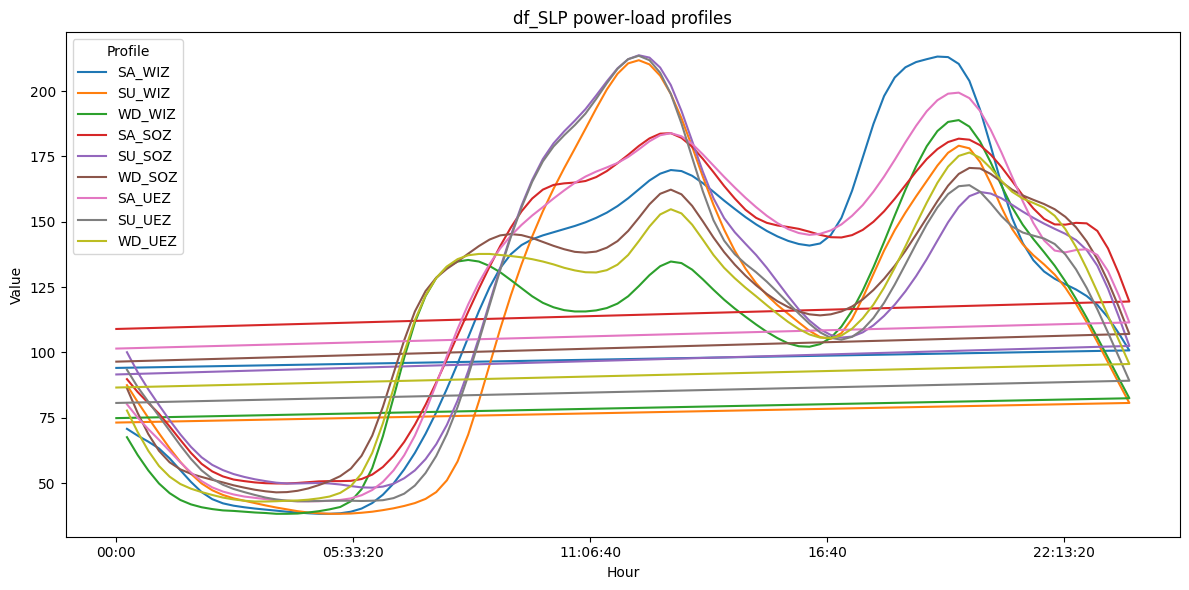

In [127]:
import matplotlib.pyplot as plt

# make sure the “Hour” column is the index and the rest are numeric
df_plot = df_SLP.set_index("Hour").apply(pd.to_numeric, errors="coerce")

plt.figure(figsize=(12, 6))
df_plot.plot(ax=plt.gca())
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("df_SLP power‑load profiles")
plt.legend(title="Profile", loc="best")
plt.tight_layout()
plt.show()

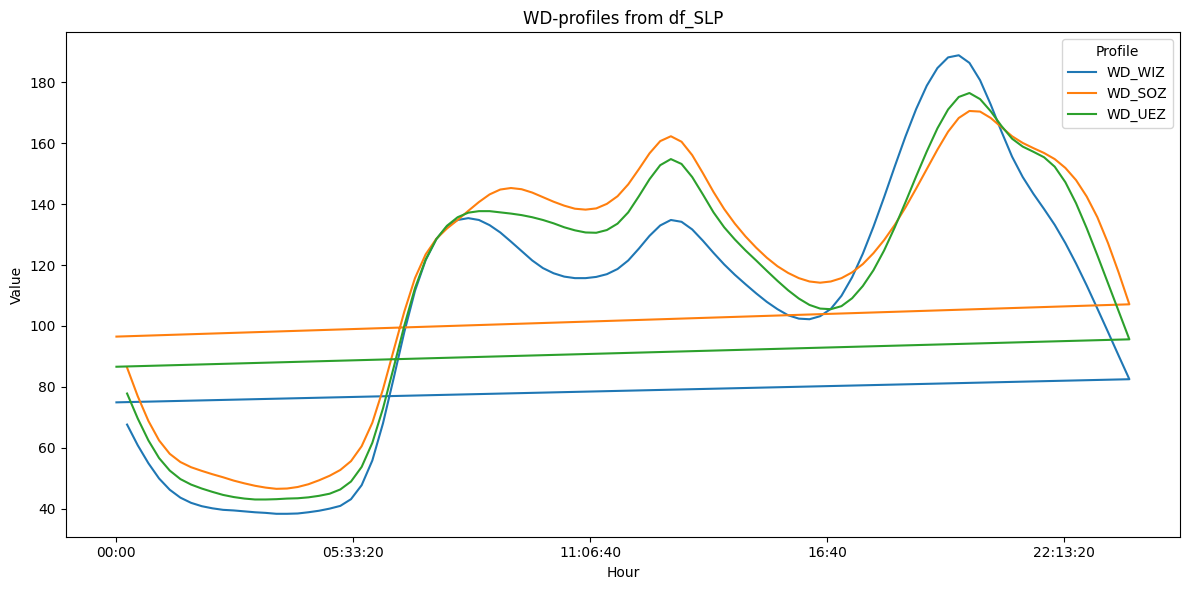

In [128]:
# choose the columns in df_SLP whose name contains "WD"
wd_cols = [c for c in df_SLP.columns if "WD" in c]

# build a numeric dataframe with Hour as index
df_wd = df_SLP.set_index("Hour")[wd_cols].apply(pd.to_numeric, errors="coerce")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_wd.plot(ax=plt.gca())
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("WD‑profiles from df_SLP")
plt.legend(title="Profile", loc="best")
plt.tight_layout()
plt.show()

In [129]:
df_wd

,WD_WIZ,WD_SOZ,WD_UEZ
Hour,,,
00:15:00,67.6,86.3,77.8
00:30:00,60.8,76.9,69.6
00:45:00,54.9,68.8,62.4
01:00:00,49.9,62.4,56.6
01:15:00,46.2,58.0,52.5
...,...,...,...
23:00:00,105.7,135.7,123.2
23:15:00,98.0,127.2,114.0
23:30:00,90.2,117.5,104.8


In [130]:
df_SLP.loc[0:len(df_SLP)-1,'Hour'] = list(df_SLP.loc[[len(df_SLP)-1] + list(range(0, len(df_SLP)-1)), 'Hour'])
        

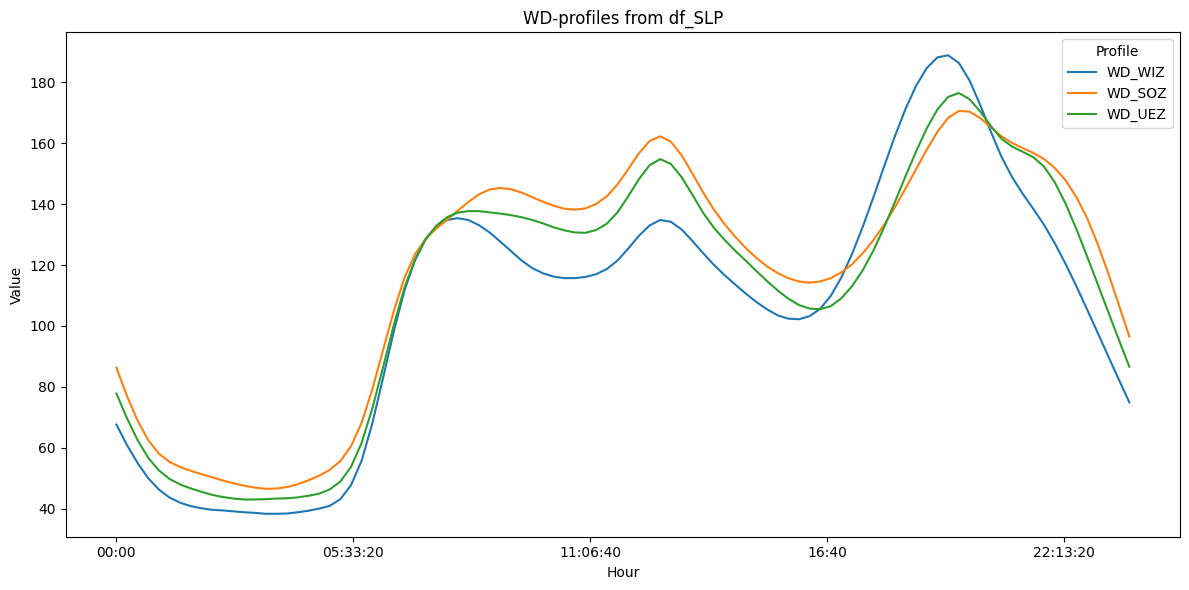

In [131]:
# choose the columns in df_SLP whose name contains "WD"
wd_cols = [c for c in df_SLP.columns if "WD" in c]

# build a numeric dataframe with Hour as index
df_wd = df_SLP.set_index("Hour")[wd_cols].apply(pd.to_numeric, errors="coerce")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_wd.plot(ax=plt.gca())
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("WD‑profiles from df_SLP")
plt.legend(title="Profile", loc="best")
plt.tight_layout()
plt.show()

In [132]:
print(df_SLP)

        Hour SA_WIZ SU_WIZ WD_WIZ SA_SOZ SU_SOZ WD_SOZ SA_UEZ SU_UEZ WD_UEZ
0   00:00:00   70.8   87.5   67.6   89.8  100.1   86.3   80.2   93.4   77.8
1   00:15:00   68.2   81.1   60.8   84.9   92.5   76.9   75.1   86.8   69.6
2   00:30:00   65.9     75   54.9   80.7   85.9   68.8   70.7   81.2   62.4
3   00:45:00   63.3   69.1   49.9   76.6   79.9   62.4   66.6   75.7   56.6
4   01:00:00   59.5   63.4   46.2   71.7   74.1     58   62.3   70.1   52.5
..       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
91  22:45:00  118.2    104  105.7  146.5  133.2  135.7  137.3  116.5  123.2
92  23:00:00  113.4   96.2     98  139.8  124.4  127.2  131.1  107.6    114
93  23:15:00  107.4   88.4   90.2  130.3  113.8  117.5  121.9   98.4  104.8
94  23:30:00  100.8   80.7   82.5  119.5  102.5  107.1  111.5   89.2   95.6
95  23:45:00   94.1   73.2   74.9    109   91.6   96.5  101.5   80.7   86.6

[96 rows x 10 columns]


In [133]:

df_SLP = df_SLP.reset_index()[
    [
        "Hour",
        "SA_WIZ",
        "SU_WIZ",
        "WD_WIZ",
        "SA_SOZ",
        "SU_SOZ",
        "WD_SOZ",
        "SA_UEZ",
        "SU_UEZ",
        "WD_UEZ",
    ]
]

In [134]:
print(df_SLP)

        Hour SA_WIZ SU_WIZ WD_WIZ SA_SOZ SU_SOZ WD_SOZ SA_UEZ SU_UEZ WD_UEZ
0   00:00:00   70.8   87.5   67.6   89.8  100.1   86.3   80.2   93.4   77.8
1   00:15:00   68.2   81.1   60.8   84.9   92.5   76.9   75.1   86.8   69.6
2   00:30:00   65.9     75   54.9   80.7   85.9   68.8   70.7   81.2   62.4
3   00:45:00   63.3   69.1   49.9   76.6   79.9   62.4   66.6   75.7   56.6
4   01:00:00   59.5   63.4   46.2   71.7   74.1     58   62.3   70.1   52.5
..       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
91  22:45:00  118.2    104  105.7  146.5  133.2  135.7  137.3  116.5  123.2
92  23:00:00  113.4   96.2     98  139.8  124.4  127.2  131.1  107.6    114
93  23:15:00  107.4   88.4   90.2  130.3  113.8  117.5  121.9   98.4  104.8
94  23:30:00  100.8   80.7   82.5  119.5  102.5  107.1  111.5   89.2   95.6
95  23:45:00   94.1   73.2   74.9    109   91.6   96.5  101.5   80.7   86.6

[96 rows x 10 columns]


In [135]:
wd_wiz = Leistung("WD_WIZ", (df.WD & df.WIZ), df, df_SLP)
wd_soz = Leistung("WD_SOZ", (df.WD & df.SOZ), df, df_SLP)
wd_uez = Leistung("WD_UEZ", (df.WD & df.UEZ), df, df_SLP)
sa_wiz = Leistung("SA_WIZ", (df.SA & df.WIZ), df, df_SLP)
sa_soz = Leistung("SA_SOZ", (df.SA & df.SOZ), df, df_SLP)
sa_uez = Leistung("SA_UEZ", (df.SA & df.UEZ), df, df_SLP)
su_wiz = Leistung("SU_WIZ", (df.SU & df.WIZ), df, df_SLP)
su_soz = Leistung("SU_SOZ", (df.SU & df.SOZ), df, df_SLP)
su_uez = Leistung("SU_UEZ", (df.SU & df.UEZ), df, df_SLP)
Summe = (
    wd_wiz
    + wd_soz
    + wd_uez
    + sa_wiz
    + sa_soz
    + sa_uez
    + su_wiz
    + su_soz
    + su_uez
)
Last = "Last_" + str(profile)
last_strings.append(Last)
df[Last] = Summe


In [136]:
if profile == 'H0':
    dofy = df['DayOfYear']
    dofy = dofy.astype(float)
    Ft = -3.92e-10 * dofy**4 + 3.2e-7 * dofy**3 - 7.02e-5 * dofy**2 + 2.1e-3 * dofy + 1.24
    df[Last] = Summe*Ft

In [137]:
print(df[Last])

0         78.744710
1         72.286153
2         66.572814
3         61.977303
4         58.748025
            ...    
35035    118.304021
35036    108.677635
35037    100.728643
35038     93.152259
35039     85.824281
Name: Last_H0, Length: 35040, dtype: float64


In [138]:
total = sum(df[Last])
df_normiert = df[Last] / total
df[profile] = df_normiert

In [139]:
df = df.drop(columns=last_strings).set_index("Date")

In [140]:
print(df.tz_convert('UTC'))

                                  Day      Hour  DayOfYear     WD     SA  \
Date                                                                       
2022-01-01 00:00:00+00:00  2022-01-01  01:00:00          1  False  False   
2022-01-01 00:15:00+00:00  2022-01-01  01:15:00          1  False  False   
2022-01-01 00:30:00+00:00  2022-01-01  01:30:00          1  False  False   
2022-01-01 00:45:00+00:00  2022-01-01  01:45:00          1  False  False   
2022-01-01 01:00:00+00:00  2022-01-01  02:00:00          1  False  False   
...                               ...       ...        ...    ...    ...   
2022-12-31 22:45:00+00:00  2022-12-31  23:45:00        365  False   True   
2022-12-31 23:00:00+00:00  2023-01-01  00:00:00          1  False  False   
2022-12-31 23:15:00+00:00  2023-01-01  00:15:00          1  False  False   
2022-12-31 23:30:00+00:00  2023-01-01  00:30:00          1  False  False   
2022-12-31 23:45:00+00:00  2023-01-01  00:45:00          1  False  False   

           

In [141]:
df = df.tz_convert('UTC')

idx = pd.date_range(start=str(year), end=str(year + 1), freq="15min")[:-1]

df.index = idx

In [142]:
print(df)

                            Day      Hour  DayOfYear     WD     SA     SU  \
2022-01-01 00:00:00  2022-01-01  01:00:00          1  False  False   True   
2022-01-01 00:15:00  2022-01-01  01:15:00          1  False  False   True   
2022-01-01 00:30:00  2022-01-01  01:30:00          1  False  False   True   
2022-01-01 00:45:00  2022-01-01  01:45:00          1  False  False   True   
2022-01-01 01:00:00  2022-01-01  02:00:00          1  False  False   True   
...                         ...       ...        ...    ...    ...    ...   
2022-12-31 22:45:00  2022-12-31  23:45:00        365  False   True  False   
2022-12-31 23:00:00  2023-01-01  00:00:00          1  False  False   True   
2022-12-31 23:15:00  2023-01-01  00:15:00          1  False  False   True   
2022-12-31 23:30:00  2023-01-01  00:30:00          1  False  False   True   
2022-12-31 23:45:00  2023-01-01  00:45:00          1  False  False   True   

                      WIZ    SOZ    UEZ        H0  
2022-01-01 00:00:00  Tr

Plot of dynamized houshold profile

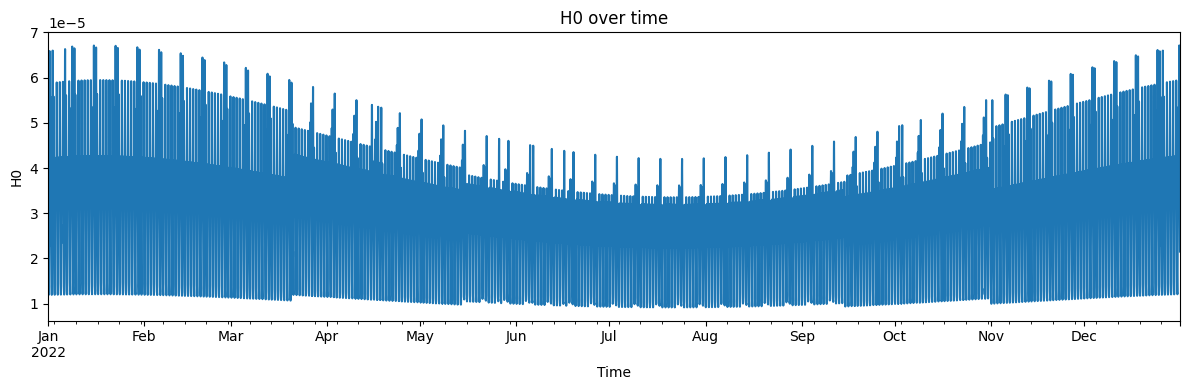

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
df['H0'].plot()
plt.xlabel('Time')
plt.ylabel('H0')
plt.title('H0 over time')
plt.tight_layout()
plt.show()

Plot of different seasons (important to take care of weekdays) 
There is always a spike when transitioning from a weekday to Sunday (e. g. public holiday). 

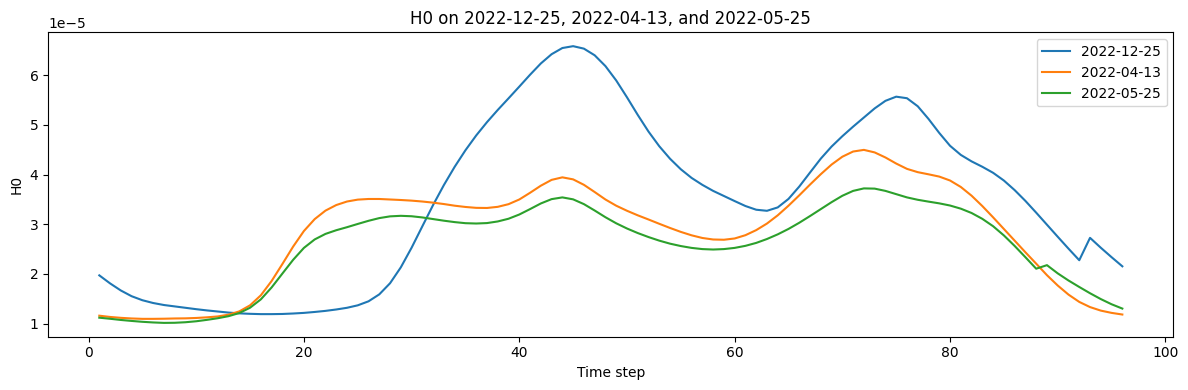

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# use simple integer steps 1…96 (15‑min steps per day)
time = np.arange(1, 97)

day_winter = "2022-12-25"
day_trans = "2022-04-13"
day_summer = "2022-05-25"

plt.figure(figsize=(12, 4))
plt.plot(time, df.loc[day_winter, "H0"].values, label=day_winter)
plt.plot(time, df.loc[day_trans, "H0"].values, label=day_trans)
plt.plot(time, df.loc[day_summer, "H0"].values, label=day_summer)
plt.xlabel("Time step")
plt.ylabel("H0")
plt.title(f"H0 on {day_winter}, {day_trans}, and {day_summer}")
plt.legend()
plt.tight_layout()
plt.show()